# **FINAL PROJECT _ Optimization Methods for Data Science** 
### A.A. 2024-2025

**Pinos Gabriel** - 1965035  
**Federico Lattanzio** - 1886519

pinos.1965035@studenti.uniroma1.it  
lattanzio.1886519@studenti.uniroma1.it

In [1]:
# Import all the necessary modules

import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from Functions_ij_Pinos_Lattanzio import (
    rbf_kernel,
    train_svm_dual_cvxopt,
    predict_svm_dual,
    cross_validate_svm_cvxopt,
    compute_kernel_matrix,
    decision_function_svm_dual,
    OneVsAllSVM 
)

## **Dataset overview**
--------

We begin by exploring the dataset `GENDER_CLASSIFICATION.csv`, which contains image embeddings extracted from a ResNet backbone, alongside gender labels:

* Feature columns: `feat_i`, representing deep features for each image.
* Target column: `gt`, where `0` corresponds to *female* and `1` to *male*.

We will use this dataset to perform **binary classification** using a Support Vector Machine (SVM).

In [2]:
# Load the gender classification dataset

gender_df = pd.read_csv("../dataset/GENDER_CLASSIFICATION.csv")
X = gender_df.drop(columns=['gt']).values
y = gender_df['gt'].values
y_svm = np.where(y == 0, -1, 1)
print(f"Dataset shape: {X.shape} | +1: {(y_svm==1).sum()} | -1: {(y_svm==-1).sum()}")

Dataset shape: (1000, 32) | +1: 500 | -1: 500


### **Dataset Inspection**

Let’s examine the structure and distribution of the gender labels.

In [3]:
# Preview the first few rows
print("First 10 entries in the dataset:")
display(gender_df.head(10))

# Print dataset shape
print(f"\n- Total samples: {len(gender_df)}")
print(f"- Feature columns: {gender_df.shape[1] - 1} (excluding target 'gt')")

First 10 entries in the dataset:


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,gt
0,-0.900846,0.102587,-0.397814,0.112796,2.588096,-0.192754,-0.968311,-0.490886,-0.872099,-0.288411,...,2.541431,1.739102,0.166066,4.584869,-0.107031,-0.913990,-0.686416,-0.368085,-0.870545,0
1,-0.838868,0.039976,-0.387101,0.055413,2.066874,-0.226948,-0.947416,-0.472817,-0.855387,-0.207101,...,1.991721,1.259745,0.065058,3.019790,-0.110633,-0.890023,-0.611625,-0.298235,-0.855208,0
2,-0.814961,-0.010184,-0.397147,0.092713,1.897454,-0.269387,-0.945285,-0.449579,-0.849705,-0.151179,...,1.822978,1.105511,0.065353,2.500681,-0.052730,-0.885691,-0.583346,-0.218140,-0.856456,0
3,-0.110470,0.027849,-0.044310,-0.005343,0.177831,-0.232092,-0.562700,-0.400713,-0.552356,0.037349,...,-0.098367,-0.370318,-0.123008,-0.861314,0.106840,-0.483669,-0.224164,0.147321,-0.615051,0
4,-0.626313,-0.091985,-0.373756,-0.005083,1.172486,-0.314868,-0.885046,-0.412587,-0.818729,-0.012022,...,1.030348,0.421886,-0.068029,0.258984,-0.057158,-0.834079,-0.441066,-0.099874,-0.829539,0
5,-0.941448,0.165438,-0.392049,0.205172,3.134455,-0.161057,-0.982058,-0.499061,-0.884788,-0.341288,...,3.115495,2.232003,0.289214,6.179787,-0.052086,-0.932607,-0.753994,-0.415275,-0.885618,0
6,-0.624388,-0.080687,-0.366623,-0.049865,1.192401,-0.295711,-0.877278,-0.429471,-0.818519,-0.060946,...,1.045350,0.420301,-0.071344,0.328387,-0.099864,-0.831247,-0.436137,-0.157848,-0.824938,0
7,-0.360967,-0.055136,-0.222737,0.087353,0.521053,-0.297690,-0.790068,-0.485822,-0.745810,0.106832,...,0.249262,-0.195481,-0.132257,-0.800665,0.101134,-0.720496,-0.286264,0.140425,-0.767403,0
8,-0.313211,-0.053253,-0.220183,0.105120,0.460798,-0.311198,-0.772821,-0.473726,-0.724301,0.113229,...,0.173077,-0.230969,-0.142840,-0.830226,0.126386,-0.694164,-0.241437,0.184116,-0.760070,0
9,1.353326,-0.034194,0.277299,-0.471843,-0.809794,0.672951,2.717927,0.928540,1.897364,-0.233773,...,-0.782136,-0.502159,0.089402,-0.468237,-0.194680,2.013506,0.288960,-0.001121,1.840473,0



- Total samples: 1000
- Feature columns: 32 (excluding target 'gt')


### **Gender Label Distribution**

We visualize the distribution of gender labels to assess class balance:

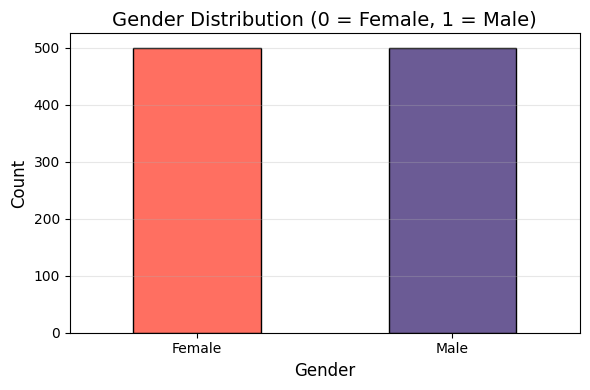

In [4]:
# Plot label distribution
plt.figure(figsize=(6, 4))
gender_df['gt'].value_counts().sort_index().plot(
    kind='bar', color=['#FF6F61', '#6B5B95'], edgecolor='black'
)
plt.title("Gender Distribution (0 = Female, 1 = Male)", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Female", "Male"], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# **Part 2: Support Vector Machines (SVM) for Gender Classification**
----

In this section, we address a binary classification task using a **Support Vector Machine** (SVM).  
Our objective is to **solve the dual quadratic optimization problem** using the **CVXOPT** library and train an SVM classifier capable of distinguishing between male and female subjects.

### **Goal**

* Implement the **dual formulation** of the SVM.
* Train using the **CVXOPT QP solver**.
* Tune the hyperparameters via **5-fold cross-validation**.
* Evaluate model performance on a **held-out test set**.

---

###  **Theoretical Background: Support Vector Machines**

A **Support Vector Machine (SVM)** is a robust and widely used supervised learning algorithm for classification tasks. Its objective is to find an optimal **separating hyperplane** that maximizes the margin between classes, in either the original or a transformed feature space.

To enable **nonlinear decision boundaries**, the SVM relies on the **kernel trick** to project input features into higher-dimensional spaces where linear separation is more feasible.

####  Nonlinear Decision Function

The decision function of the kernel SVM is defined as:

$$
f(x) = \text{sign} \left( \sum_{i=1}^{N} \lambda_i y_i \, k(x_i, x) + b \right)
$$

where:

* $x_i \in \mathbb{R}^d$: training samples
* $y_i \in \{-1, +1\}$: class labels
* $\lambda_i$: Lagrange multipliers (learned from optimization)
* $k(\cdot, \cdot)$: kernel function
* $b$: bias term
* $x$: new input sample

Only the **support vectors** (training samples with $\lambda_i > 0$) influence the decision function.

---

####  Dual Optimization Problem

Training an SVM is equivalent to solving the following **convex Quadratic Programming (QP)** problem in the dual form:

$$
\max_{\boldsymbol{\lambda}} \quad \sum_{i=1}^{N} \lambda_i - \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \lambda_i \lambda_j y_i y_j \, k(x_i, x_j)
$$

subject to:

$$
0 \leq \lambda_i \leq C, \quad \sum_{i=1}^{N} \lambda_i y_i = 0
$$

* $C$: regularization parameter that balances margin maximization and misclassification.
* $\boldsymbol{\lambda}$: solution vector containing dual variables.

---

####  Kernel Functions

To operate in a nonlinear setting, we replace the dot product $x^\top x'$ with a **kernel function** $k(x, x')$, which computes similarity in a **reproducing kernel Hilbert space (RKHS)** without explicit transformation.

The most commonly used kernels include:

* **Radial Basis Function (RBF / Gaussian)**:

  $$
  k(x, x') = \exp \left(-\gamma \|x - x'\|^2 \right)
  $$

  * $\gamma$: controls the influence radius of support vectors
  * Suitable for complex, smooth decision boundaries

* **Polynomial Kernel**:

  $$
  k(x, x') = \left(x^\top x' + 1 \right)^p
  $$

  * $p$: polynomial degree
  * Captures interactions up to degree $p$

---

####  Hyperparameter Tuning

The following hyperparameters need to be tuned via **k-fold cross-validation** to balance generalization and accuracy:

* $C$: regularization strength
* $\gamma$: RBF kernel parameter
* $p$: degree for the polynomial kernel

Proper tuning of these parameters is crucial to avoid both **underfitting** and **overfitting**, and to ensure robust performance on unseen data.


-----



## **Setup and Preprocessing**

We now prepare the data for training:



In [5]:
# Separate features and labels
X = gender_df.drop(columns=['gt']).values
y = gender_df['gt'].values

# Map labels from {0,1} → {-1, +1} for SVM
y_svm = np.where(y == 0, -1, 1)

print(f"Dataset shape: {X.shape}")
print(f"Positive samples (label = +1): {np.sum(y_svm == 1)}")
print(f"Negative samples (label = -1): {np.sum(y_svm == -1)}")

Dataset shape: (1000, 32)
Positive samples (label = +1): 500
Negative samples (label = -1): 500


### **Train-Test Split**
After selecting the best configuration, we isolate a hold-out test set (20%) and reserve the remaining 80% for training the final model.

In [7]:
# Hold‑out test: 20%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y_svm, test_size=0.20, random_state=42, stratify=y_svm
)
print(f"Train+Val: {X_trainval.shape[0]} | Test: {X_test.shape[0]}")

Train+Val: 800 | Test: 200


## **Hyperparameter Tuning via Cross-Validation**

We perform **5-fold cross-validation** to select the best combination of:

* $C$: regularization strength
* $\gamma$: RBF kernel parameter


In [8]:

# Define hyperparameter grid
C_values = [1e-2, 1, 10]
gamma_values = [1e-4, 1e-2, 1]

print("Starting cross-validation (RBF kernel)...")
(best_C, best_gamma, best_accuracy), all_results = cross_validate_svm_cvxopt(
    X_trainval, y_trainval, C_values, gamma_values, k_folds=5
)

Starting cross-validation (RBF kernel)...
C=0.01, gamma=0.0001 → avg val acc: 0.9100
C=0.01, gamma=0.01 → avg val acc: 0.9088
C=0.01, gamma=1 → avg val acc: 0.9062
C=1, gamma=0.0001 → avg val acc: 0.9050
C=1, gamma=0.01 → avg val acc: 0.9163
C=1, gamma=1 → avg val acc: 0.9100
C=10, gamma=0.0001 → avg val acc: 0.9163
C=10, gamma=0.01 → avg val acc: 0.9138
C=10, gamma=1 → avg val acc: 0.8863


Once completed, we extract the best configuration based on the highest average validation accuracy:

In [9]:
# Retrieve best configuration
print("\nBest hyperparameters:")
print(f" - Kernel  : RBF")
print(f" - C       : {best_C}")
print(f" - gamma   : {best_gamma}")
print(f" - CV Acc. : {best_accuracy:.4f}")


Best hyperparameters:
 - Kernel  : RBF
 - C       : 1
 - gamma   : 0.01
 - CV Acc. : 0.9163


### **Final Model Training**
We now train the final SVM model using the best C and gamma, solving the dual optimization problem via CVXOPT.

In [10]:
# Fit scaler su tutto il train+val e applica a train+val e test
scaler = StandardScaler()
X_trainval_sc = scaler.fit_transform(X_trainval)
X_test_sc     = scaler.transform(X_test)

# Kernel function
kernel_final = lambda A, B: rbf_kernel(A, B, gamma=best_gamma)


In [11]:
# Train final model

# Train final model with CVXOPT

alpha, sv_idx, b, final_obj, n_iter, status, opt_time = train_svm_dual_cvxopt(
    X_trainval_sc, y_trainval, kernel_final, C=best_C
)

print(" Final model trained")
print(f" - Status               : {status}")
print(f" - Iterations           : {n_iter}")
print(f" - Dual Objective (final): {final_obj:.6f}")
print(f" - Optimization Time [s]: {opt_time:.4f}")
print(f" - Support Vectors      : {len(sv_idx)} / {len(alpha)}")

# Predizioni e metriche su TRAIN
y_pred_train = predict_svm_dual(
    X_trainval_sc, y_trainval, X_trainval_sc, alpha, b, kernel_final
)
acc_train = accuracy_score(y_trainval, y_pred_train)
cm_train = confusion_matrix(y_trainval, y_pred_train)

print("\n TRAIN PERFORMANCE")
print(f" - Train Accuracy       : {acc_train:.4f}")
print(" - Confusion Matrix (Train):")
print(cm_train)


 Final model trained
 - Status               : optimal
 - Iterations           : 18
 - Dual Objective (final): -154.879445
 - Optimization Time [s]: 0.4246
 - Support Vectors      : 172 / 800

 TRAIN PERFORMANCE
 - Train Accuracy       : 0.9175
 - Confusion Matrix (Train):
[[366  34]
 [ 32 368]]


### **Test Set Evaluation**
We evaluate model performance using accuracy and a confusion matrix on the unseen test set.

In [12]:
# Predict on test set
y_pred_test = predict_svm_dual(
    X_trainval_sc, y_trainval, X_test_sc, alpha, b, kernel_final
)
acc_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)

print("\n TEST PERFORMANCE")
print(f" - Test Accuracy        : {acc_test:.4f}")
print(" - Confusion Matrix (Test):")
print(cm_test)



 TEST PERFORMANCE
 - Test Accuracy        : 0.9250
 - Confusion Matrix (Test):
[[93  7]
 [ 8 92]]


### **Visualization**

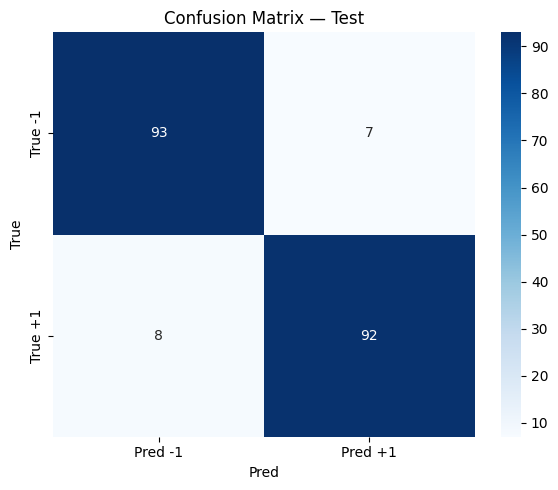

In [13]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred -1','Pred +1'],
            yticklabels=['True -1','True +1'])
plt.title("Confusion Matrix — Test")
plt.ylabel("True")
plt.xlabel("Pred")
plt.tight_layout()
plt.show()

### **Cross-Validation Results Heatmap**

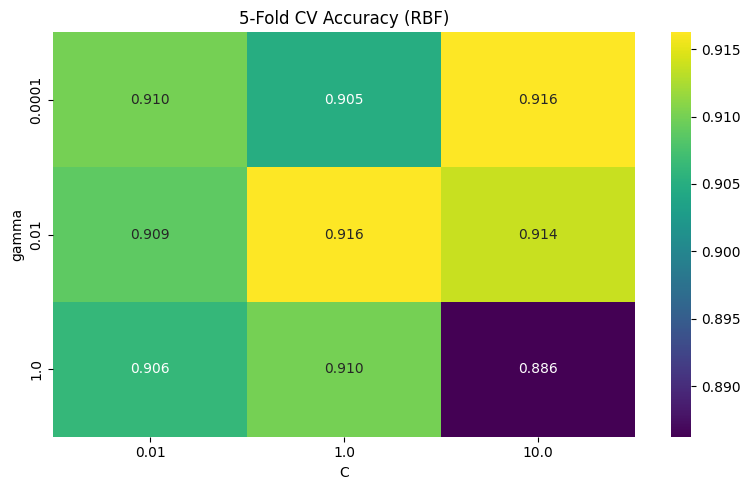

In [14]:
# CV results heatmap

cv_df = pd.DataFrame(all_results, columns=["C", "gamma", "accuracy"])
pivot = cv_df.pivot(index="gamma", columns="C", values="accuracy").sort_index().sort_index(axis=1)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("5-Fold CV Accuracy (RBF)")
plt.xlabel("C")
plt.ylabel("gamma")
plt.tight_layout()
plt.show()

### **Final Summary**

In [19]:
print("\n" + "="*70)
print("{:^70}".format("FINAL SUMMARY"))
print("="*70)

print(f"{'Samples (total)':25} : {X.shape[0]}")
print(f"{'Features':25} : {X.shape[1]}")
print(f"{'Kernel':25} : RBF")
print(f"{'Best C':25} : {best_C}")
print(f"{'Best gamma':25} : {best_gamma}")
print(f"{'CV Accuracy (mean)':25} : {best_accuracy:.4f}")
print("-"*70)
print(f"{'Train Accuracy':25} : {acc_train:.4f}")
print(f"{'Test Accuracy':25} : {acc_test:.4f}")
print("-"*70)
print(f"{'# Support Vectors':25} : {len(sv_idx)}")
print(f"{'SV Ratio':25} : {len(sv_idx)/len(alpha):.2%}")
print("-"*70)
print(f"{'Optimization Status':25} : {status}")
print(f"{'Iterations':25} : {n_iter}")
print(f"{'Dual Objective (final)':25} : {final_obj:.6f}")
print(f"{'Optimization Time [s]':25} : {opt_time:.4f}")
print("="*70)

print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred_test, target_names=["Class -1", "Class +1"]))



                            FINAL SUMMARY                             
Samples (total)           : 1500
Features                  : 32
Kernel                    : RBF
Best C                    : 1
Best gamma                : 0.01
CV Accuracy (mean)        : 0.9163
----------------------------------------------------------------------
Train Accuracy            : 0.9175
Test Accuracy             : 0.9250
----------------------------------------------------------------------
# Support Vectors         : 172
SV Ratio                  : 21.50%
----------------------------------------------------------------------
Optimization Status       : optimal
Iterations                : 18
Dual Objective (final)    : -154.879445
Optimization Time [s]     : 0.4246

Classification Report (Test):

              precision    recall  f1-score   support

    Class -1       0.92      0.93      0.93       100
    Class +1       0.93      0.92      0.92       100

    accuracy                           0.93   

## **BONUS Question 4 – Multiclass SVM (One-vs-All)**

In this bonus task, we extend the binary SVM formulation to the case of **multiclass ethnicity classification**.  
From the five ethnic groups available, we select three classes and implement the **One-vs-All (OvA)** strategy:

- For each class, a binary classifier is trained to separate it from the remaining classes.  
- At prediction time, the class with the **highest decision function value** is assigned.  

This approach reuses the optimization routine previously implemented for the binary SVM.


In [20]:
# Load and filter the dataset (3 classes only)
eth = pd.read_csv("../dataset/ETHNICITY_CLASSIFICATION.csv")
classes_to_use = [0, 1, 2]
eth = eth[eth["gt"].isin(classes_to_use)].copy()

X = eth.drop(columns=["gt"]).values
y = eth["gt"].values

# Stratified split
X_tr, X_ts, y_tr, y_ts = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

# Standardize features (important for RBF/Polynomial kernels)
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_ts = scaler.transform(X_ts)

### **Training phase**

We train the OvA-SVM model using an **RBF kernel** with parameters fixed to  
$\gamma = 0.01$ and $C = 1.0$.  
No cross-validation is required for the bonus question, but these hyperparameters can be adjusted empirically.


In [21]:
gamma = 0.01
kernel = lambda A, B: rbf_kernel(A, B, gamma=gamma)
C = 1.0

ova = OneVsAllSVM(kernel=kernel, C=C)
ova.fit(X_tr, y_tr)

### **Evaluation**

Model performance is reported in terms of **accuracy** on both training and test sets.  
We also provide the **confusion matrices** to analyze class-specific behavior.

In [22]:
y_pred_tr = ova.predict(X_tr)
y_pred_ts = ova.predict(X_ts)

acc_tr = accuracy_score(y_tr, y_pred_tr)
acc_ts = accuracy_score(y_ts, y_pred_ts)
cm_tr  = confusion_matrix(y_tr, y_pred_tr, labels=classes_to_use)
cm_ts  = confusion_matrix(y_ts, y_pred_ts, labels=classes_to_use)

print("=== BONUS: ETHNICITY (OvA, 3 classes) ===")
print(f"Classes used            : {classes_to_use}")
print(f"Kernel                  : RBF (gamma={gamma})")
print(f"C                       : {C}")
print(f"Accuracy TRAIN          : {acc_tr:.4f}")
print(f"Accuracy TEST           : {acc_ts:.4f}")
print("Confusion Matrix (TRAIN):")
print(cm_tr)
print("Confusion Matrix (TEST) :")
print(cm_ts)


=== BONUS: ETHNICITY (OvA, 3 classes) ===
Classes used            : [0, 1, 2]
Kernel                  : RBF (gamma=0.01)
C                       : 1.0
Accuracy TRAIN          : 0.9158
Accuracy TEST           : 0.8800
Confusion Matrix (TRAIN):
[[363  20  17]
 [ 17 376   7]
 [ 24  16 360]]
Confusion Matrix (TEST) :
[[88 10  2]
 [ 8 88  4]
 [ 9  3 88]]
